In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from collections import OrderedDict

%matplotlib inline

In [5]:
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#!unzip -qq flower_data.zip

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
batch_size=8
num_workers=0

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
      'test': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
     'test2': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = '..\\flowers\\flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test', 'test2']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid', 'test2']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test', 'test2']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import json
with open('cat_to_name.json', 'r') as f:
#with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#cat_to_name = {int(n):cat_to_name[n] for n in cat_to_name}
#sorted_keys = sorted(cat_to_name.keys())
classes=[]
for i in image_datasets['train'].classes:
    classes.append(cat_to_name[i])


In [8]:
import json
#with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

In [9]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print(torch.cuda.is_available())
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    


True
CUDA is available!  Training on GPU ...


In [10]:

model_ft = models.densenet161(pretrained=True)
model_ft.classifier
model_ft.class_to_idx = image_datasets['train'].class_to_idx

In [11]:

n_inputs = 2208
# Freeze parameters so we don't backprop through them
for param in model_ft.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_ft.classifier = classifier
model_ft = model_ft.to(device)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
#try with
#optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)






In [12]:
import time
import copy
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
           #            num_epochs=45)

In [ ]:
model_ft.class_to_idx = image_datasets['train'].class_to_idx
model_ft.cpu()
#torch.save({'model': 'densenet161',
#            'state_dict': model_ft.state_dict(), 
#            'class_to_idx': model_ft.class_to_idx}, 
#            'drive/My Drive/Colab Notebooks/classifier18dec.pth')

In [14]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['model'] == 'densenet161':
        model = models.densenet161(pretrained=False)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
      
    
    model.class_to_idx = chpt['class_to_idx']
    from collections import OrderedDict
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [15]:

def load_checkpoint(model, optimizer, filename='trained_classifier.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        state_dict=model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, loss, state_dict

In [ ]:
#retrain checkpoint28dec_retrain3.pth 0.991443
checkpoint, optimizer, start_epoch, loss, state_dict = load_checkpoint(model_ft, optimizer_ft, 'checkpoint28dec_retrain4.pth')
checkpoint.cuda()

In [18]:
def retrain_model(model, criterion, optimizer, scheduler, state_dict, loss, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        if epoch == 20:
            for param in model_ft.parameters():
                param.requires_grad = True
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                print('Accuracy increased ({:.6f} --> {:.6f}).  Saving model checkpoint28dec ...'.format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save model if loss has decreased   
                torch.save({'epoch': epoch + 1,
                                 'state_dict': model.state_dict(),
                                 'optimizer' : optimizer.state_dict(),
                                 'model': 'densenet161',
                                 'loss': loss, 
                                 'class_to_idx': model_ft.class_to_idx},
                                 'checkpoint10jul_retrain.pt'
                                )
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
retrain_model(checkpoint, criterion, optimizer, exp_lr_scheduler, state_dict, loss, num_epochs=1)

In [ ]:
torch.save({'model': 'densenet161',
            'state_dict': checkpoint.state_dict(), 
            'class_to_idx': model_ft.class_to_idx}, 
            'classifier10jul_retrained.pt')

In [ ]:
#classifier28dec_retrained after 3 epochs
model_rt = load_model('classifier10jul_retrained.pt')
model_rt.cuda()

In [17]:
def imshow1(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   

In [18]:
def visualize_model(model, num_images=8):
    model.cuda()
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            print(inputs.size()[0])
            
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far) #subplot(nrows, ncols, index, **kwargs)
                #ax = plt.subplot(num_images//2, 2, j+1, xticks=[], yticks=[])
                ax.axis('off')
                ax.set_title('{}'.format(classes[preds[j]]) + ' ({})'.format(classes[labels[j]]), color=("green" if preds[j]==labels[j] else "red"))
               
                imshow1(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([38, 17, 82, 90, 43,  3, 93, 74], device='cuda:0')
8


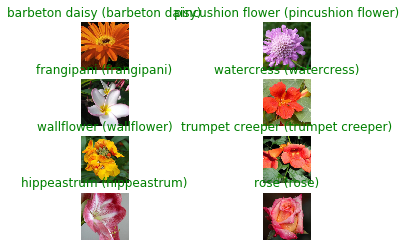

In [19]:
visualize_model(model_rt)

In [20]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data):
            inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print("predicted flower type", predicted) #the predicted class
                print("label data", labels.data)
                print("how sure is model", torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print("correct or not", equals)
            print("accuracy for each batch", equals.float().mean())

In [35]:
#classifier28dec_retrained 3epochs
calc_accuracy(model_rt, dataloaders['valid'])

predicted flower type tensor([ 18,  89,  74,  53, 100,  73,  82, 101], device='cuda:0')
label data tensor([ 18,  89,  74,  53, 100,  73,  82,  93], device='cuda:0')
how sure is model tensor([0.9998, 1.0000, 0.9915, 1.0000, 1.0000, 1.0000, 0.9999, 0.4827],
       device='cuda:0')
correct or not tensor([1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0', dtype=torch.uint8)
accuracy for each batch tensor(0.8750, device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy for each batch tensor(1., device='cuda:0')
accuracy

In [27]:
import os
import random
import sys
import urllib.request



def calc_accuracy_testset(model, input_image_size, use_google_testset=False, testset_path=None, batch_size=32,
                  norm_mean=[0.485, 0.456, 0.406], norm_std=[0.229, 0.224, 0.225]):
    """
    Calculate the mean accuracy of the model on the test test
    :param use_google_testset: If true use the testset derived from google image
    :param testset_path: If None, use a default testset (missing image from the Udacity dataset,
    downloaded from here: http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz)
    :param batch_size:
    :param model:
    :param input_image_size:
    :param norm_mean:
    :param norm_std:
    :return: the mean accuracy
    
    if use_google_testset:
        testset_path = "./google_test_data"
        url = 'https://www.dropbox.com/s/3zmf1kq58o909rq/google_test_data.zip?dl=1'
        download_test_set(testset_path, url)
    if testset_path is None:
        testset_path = "./flower_data_orginal_test"
        url = 'https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1'
        download_test_set(testset_path, url)"""
    testset_path = "../flower_data_orginal_test"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        batch_accuracy = []
        torch.manual_seed(33)
        torch.cuda.manual_seed(33)
        np.random.seed(33)
        random.seed(33)
        torch.backends.cudnn.deterministic = True
        """datatransform = transforms.Compose([#transforms.RandomRotation(45),
                                            #transforms.Resize(input_image_size + 32),
                                            transforms.RandomRotation(30),
                                            transforms.Resize(input_image_size + 32),
                                            transforms.CenterCrop(input_image_size),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            

        datatransform = transforms.Compose([ #transforms.RandomRotation(45),
                                            transforms.Resize(226),
                                            transforms.CenterCrop(224),
                                            #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                                            #transforms.ColorJitter(),
                                            #transforms.RandomHorizontalFlip(),
                                            #transforms.RandomVerticalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])"""
        
       
            
        #image_dataset = datasets.ImageFolder(testset_path, transform=datatransform)
        #dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=True)
        for idx, (inputs, labels) in enumerate(dataloaders['test2']):
            if device == 'cuda':
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model.forward(inputs)
            _, predicted = outputs.max(dim=1)
            equals = predicted == labels.data
           # print("Batch accuracy (Size {}): {}".format(batch_size, equals.float().mean()))
            batch_accuracy.append(equals.float().mean().cpu().numpy())
        mean_acc = np.mean(batch_accuracy)
        print("Mean accuracy: {}".format(mean_acc))
    return mean_acc

In [ ]:
#classifier28dec_retrained second try from Kaggle
#different transforms
valid_dir= "../flower_data/test2"

calc_accuracy_testset(model_rt, input_image_size=224, testset_path=valid_dir)

In [22]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model_rt.eval() # eval mode

# iterate over test data
for data, target in dataloaders['valid']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_rt(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(dataloaders['valid'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))



Test Loss: 0.064359



In [23]:
for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        print(100 * class_correct[i] / class_total[i])

             
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of pink primrose: 100% ( 8/ 8)
100.0
Test Accuracy of globe thistle: 100% ( 4/ 4)
100.0
Test Accuracy of blanket flower: 100% ( 6/ 6)
100.0
Test Accuracy of trumpet creeper: 100% ( 5/ 5)
100.0
Test Accuracy of blackberry lily: 100% ( 6/ 6)
100.0
Test Accuracy of snapdragon: 100% (10/10)
100.0
Test Accuracy of colt's foot: 100% ( 5/ 5)
100.0
Test Accuracy of king protea: 100% ( 5/ 5)
100.0
Test Accuracy of spear thistle: 100% ( 1/ 1)
100.0
Test Accuracy of yellow iris: 100% ( 7/ 7)
100.0
Test Accuracy of globe-flower: 100% ( 2/ 2)
100.0
Test Accuracy of purple coneflower: 100% (16/16)
100.0
Test Accuracy of peruvian lily: 100% (11/11)
100.0
Test Accuracy of balloon flower: 100% ( 4/ 4)
100.0
Test Accuracy of hard-leaved pocket orchid: 100% ( 6/ 6)
100.0
Test Accuracy of giant white arum lily: 85% ( 6/ 7)
85.71428571428571
Test Accuracy of fire lily: 100% ( 4/ 4)
100.0
Test Accuracy of pincushion flower: 100% ( 8/ 8)
100.0
Test Accuracy of fritillary: 100% (12/12)
100.0
Tes

In [26]:
for i in range(102):        
        if 100 * class_correct[i] / class_total[i] < 100:
            print('Test Accuracy non accurate of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

Test Accuracy non accurate of giant white arum lily: 85% ( 6/ 7)
Test Accuracy non accurate of ruby-lipped cattleya: 83% ( 5/ 6)
Test Accuracy non accurate of sweet pea: 83% ( 5/ 6)
Test Accuracy non accurate of morning glory: 95% (19/20)
Test Accuracy non accurate of hippeastrum: 77% ( 7/ 9)
Test Accuracy non accurate of ball moss: 83% ( 5/ 6)
Test Accuracy non accurate of foxglove: 92% (13/14)
Test Accuracy non accurate of camellia: 90% ( 9/10)


In [62]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 226))
    else:
        img.thumbnail((226, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [63]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

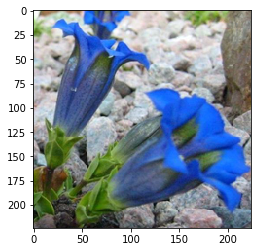

In [64]:
#image_path = 'drive/My Drive/Colab Notebooks/flower_data/valid/28/image_05272.jpg'
image_path = './flower_data/valid/28/image_05272.jpg'
img = process_image(image_path)
imshow(img)

In [65]:
# Process image
img = process_image(image_path) 
img = torch.from_numpy(img).type(torch.cuda.FloatTensor) 
img.unsqueeze_(0)
# Predict top 5
#moved loaded model to gpu
probs = torch.exp(model_rt.cuda().forward(img)) 
top_probs, top_labs = probs.topk(5)
top_probs.cpu()
top_labs.cpu()

tensor([[23, 20, 29, 66, 25]])

In [66]:
top_probs = top_probs.detach().cpu().numpy().tolist()[0]
top_labs = top_labs.detach().cpu().numpy().tolist()[0]

In [ ]:
idx_to_class = {val: key for key, val in model_rt.class_to_idx.items()}
#print(idx_to_class)

In [68]:
top_labels = [idx_to_class[lab] for lab in top_labs]

In [69]:
top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

In [70]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [ ]:
#!pip install seaborn

In [76]:
import seaborn as sns
def plot_solution(image_path, model, path_num):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[path_num]
    print(flower_num)
    title_ = label_map[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model.cpu()) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [77]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

39


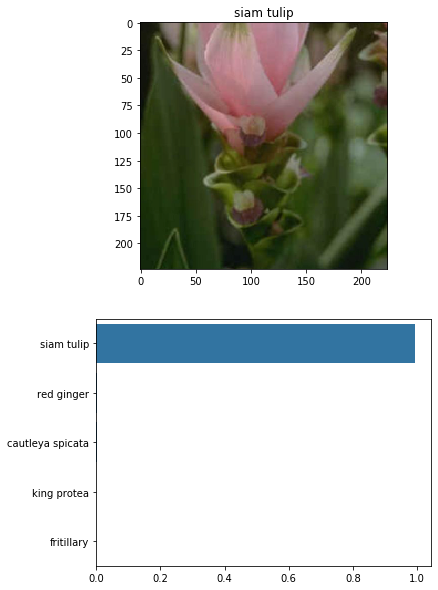

In [81]:
image_path = "flower_data/valid/39/image_07013.jpg"
plot_solution(image_path, model_rt, 2)

10


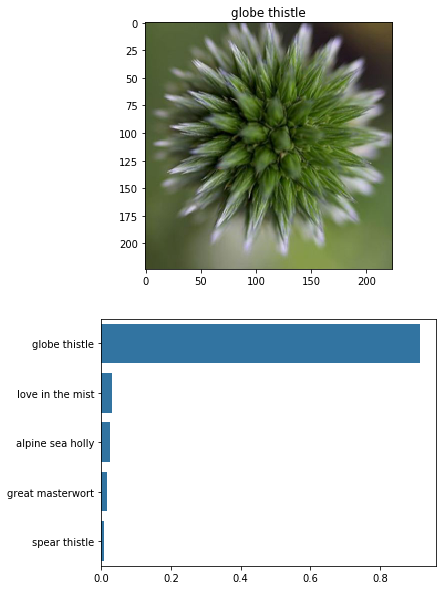

In [83]:
image_path = "flower_data/valid/10/image_07101.jpg"
plot_solution(image_path, model_rt, 2)

7


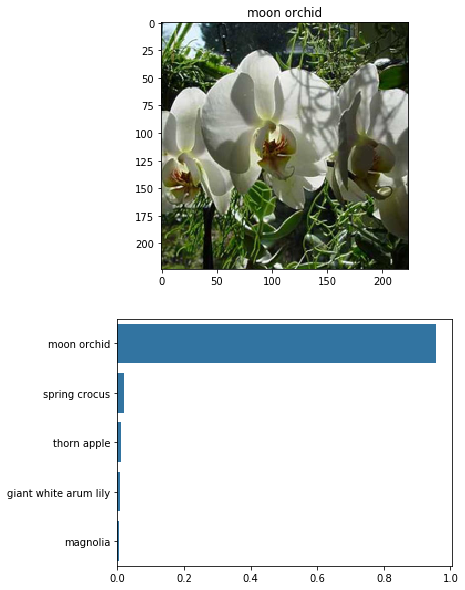

In [84]:
image_path = "flower_data/valid/7/image_07216.jpg"
plot_solution(image_path, model_rt, 2)

4


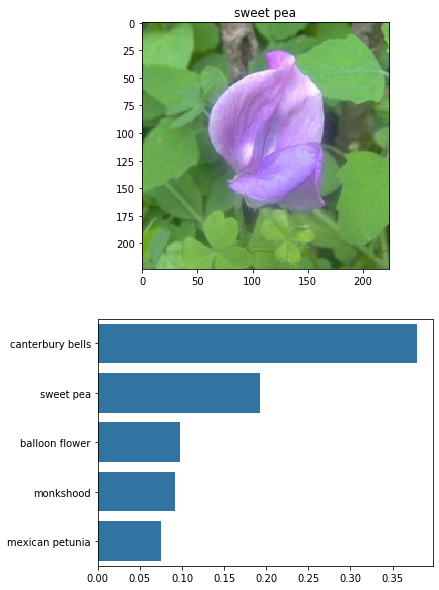

In [85]:
image_path = "flower_data/valid/4/image_05660.jpg"
plot_solution(image_path, model_rt, 2)

53


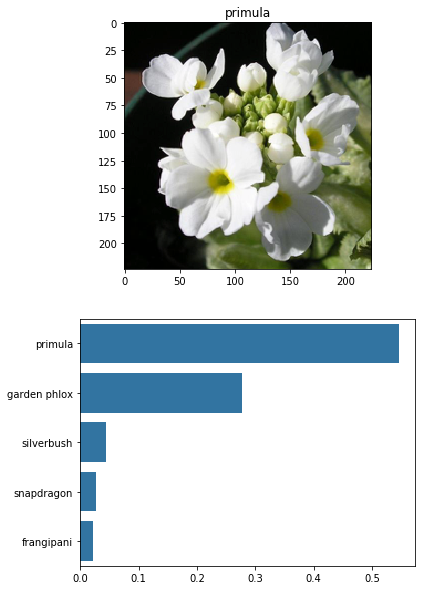

In [86]:
image_path = "flower_data/valid/53/image_03693.jpg"
plot_solution(image_path, model_rt, 2)

20


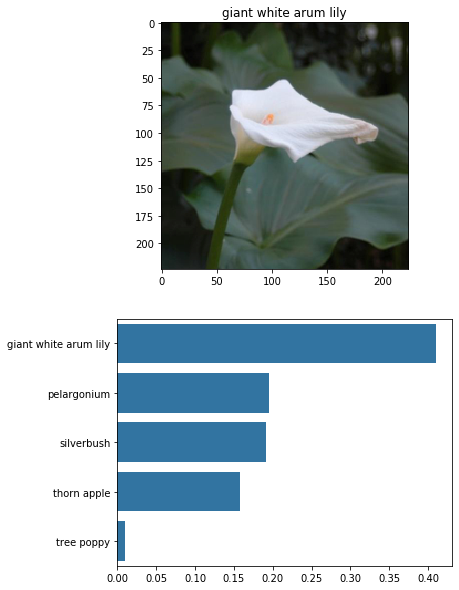

In [98]:
image_path = "flower_data/test2/20/image_04938.jpg"
plot_solution(image_path, model_rt, 2)

20


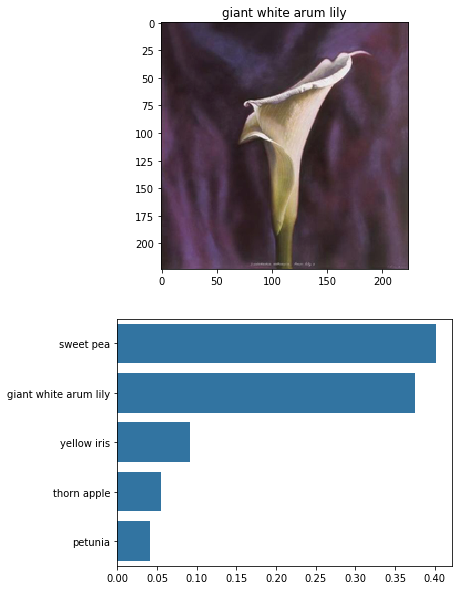

In [90]:
image_path = "flower_data/valid/20/image_04927.jpg"
plot_solution(image_path, model_rt, 2)

20


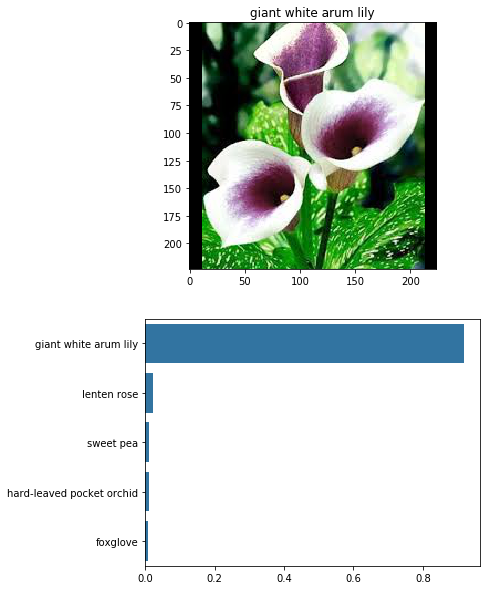

In [91]:
image_path = "flower_data/test/20/callapicasso.jpg"
plot_solution(image_path, model_rt, 2)

20


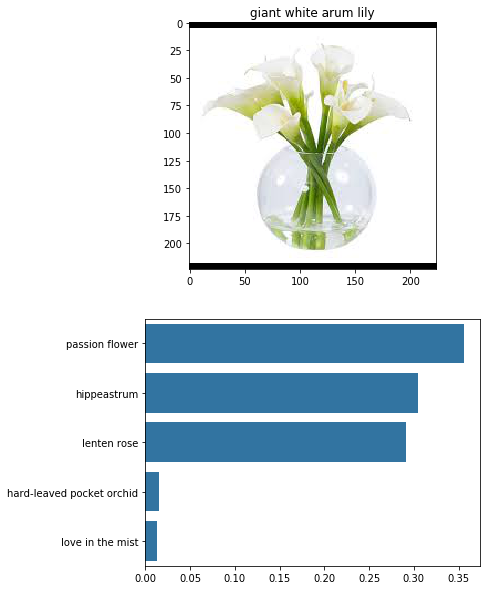

In [92]:
image_path = "flower_data/test/20/callavaso.jpg"
plot_solution(image_path, model_rt, 2)

36


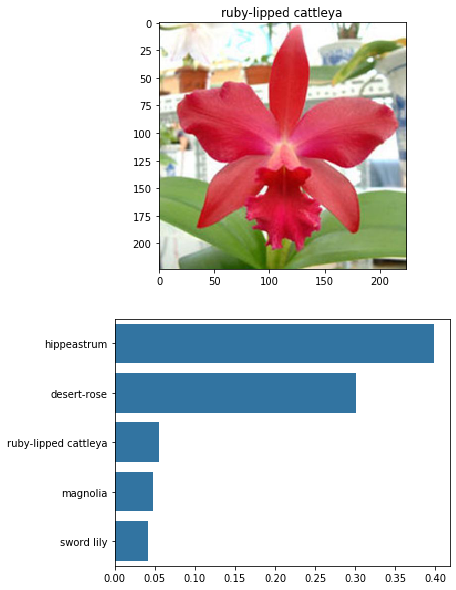

In [93]:
image_path = "flower_data/valid/36/image_04333.jpg"
plot_solution(image_path, model_rt, 2)

31


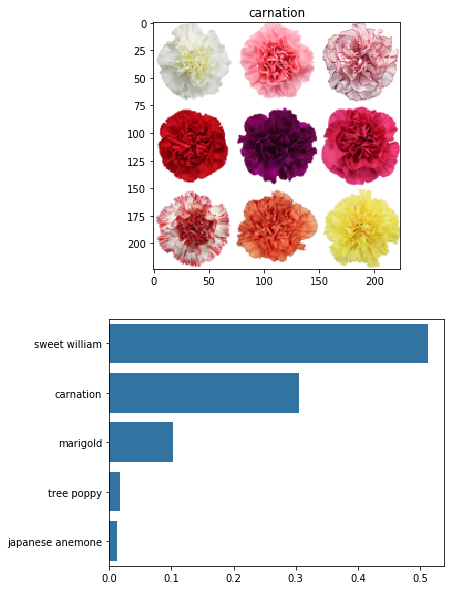

In [261]:
image_path = "flower_data_orginal_test/31/1. mixed-color-carnations-500_8f2e1b09.jpg"
plot_solution(image_path, model_rt, 2)


1


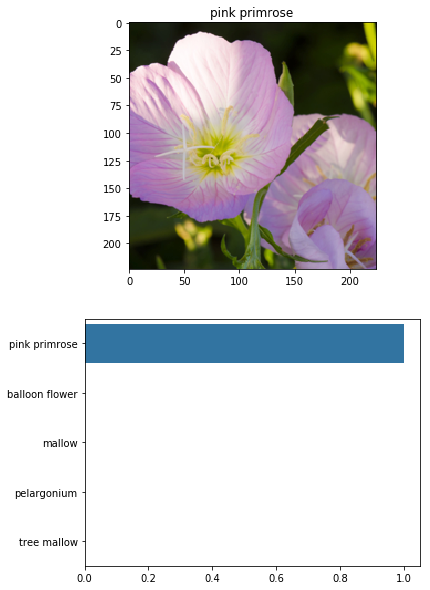

In [237]:
image_path = "../flower_data_orginal_test/1/2. evening_primrose_flower-595735926.jpg"
plot_solution(image_path, model_rt, 2)



36


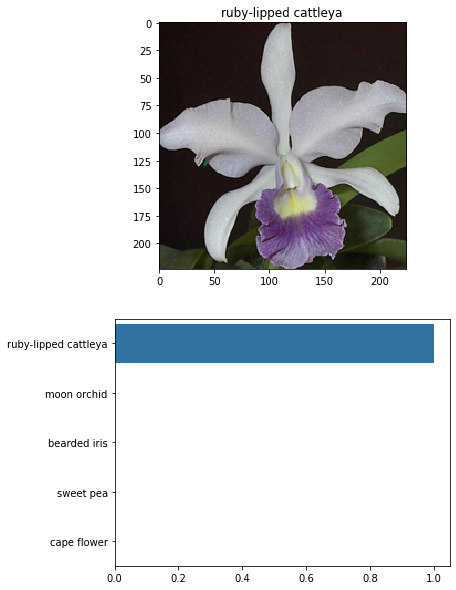

In [94]:
image_path = "flower_data/test2/36/image_04382.jpg"
plot_solution(image_path, model_rt, 2)

13


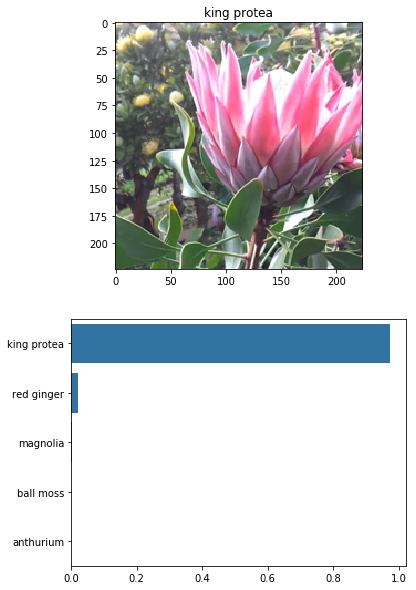

In [264]:
image_path = "../flower_data_orginal_test/13/8. maxresdefault.jpg"
plot_solution(image_path, model_rt, 2)

96


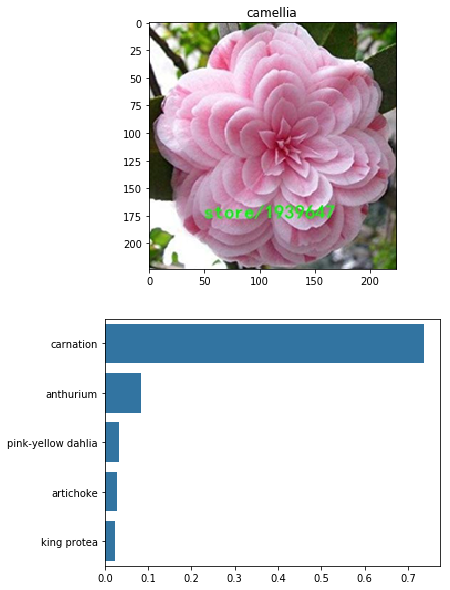

In [268]:
image_path = "../flower_data_orginal_test/96/9. 51uhyt31vel._sl500_ac_ss350_.jpg"
plot_solution(image_path, model_rt, 2)


97


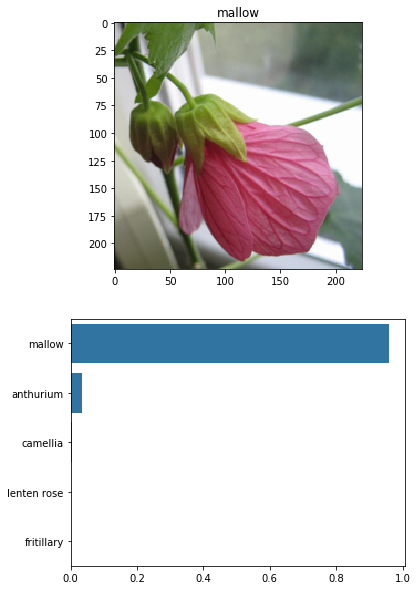

In [95]:
image_path = "flower_data/test2/97/image_07708.jpg"
plot_solution(image_path, model_rt, 2)

86


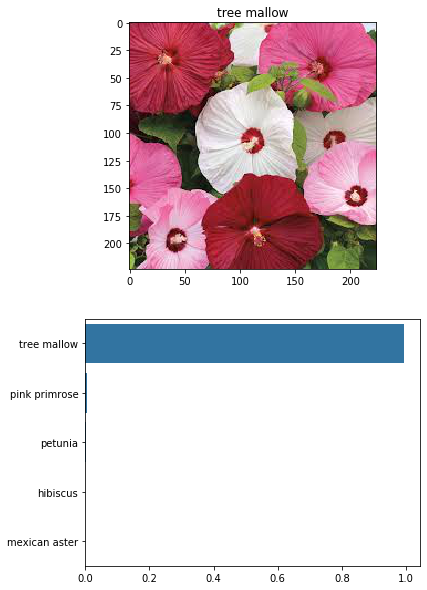

In [96]:
image_path = "flower_data/test/86/mixrosemallow.jpg"
plot_solution(image_path, model_rt, 2)

86


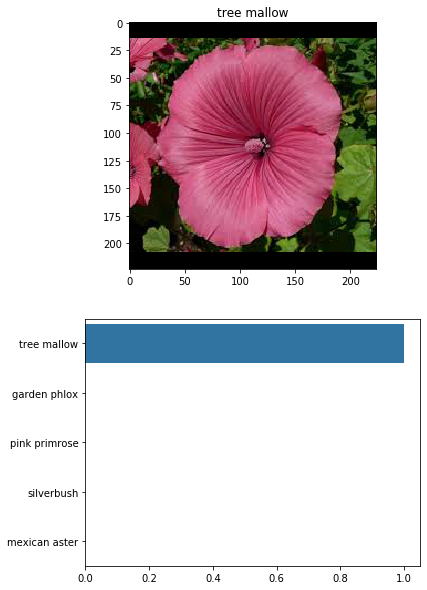

In [97]:
image_path = "flower_data/test/86/rosemallow.jpg"
plot_solution(image_path, model_rt, 2)